## Import libraries

In [1]:
import torch
import os.path as op
import nibabel as nib
import numpy as np
from nilearn import plotting

import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import SimulationDataset
from model import Autoencoder3D

/Users/greg/code/gkiar/3d-cnn-ae/env/cnn/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Create helper functions

In [3]:
def groom(im):
    if isinstance(im, nib.Nifti1Image):
        sample = im
    else:
        sample = nib.load(im)
    sample = sample.get_data().copy().astype(float)
    sample = np.nan_to_num(sample)
    sample = torch.tensor(sample).view((1), (1), *sample.shape)
    return sample.type('torch.FloatTensor')

In [4]:
def recreate_im(immat):
    tmpdat = immat.detach().numpy().reshape(*immat.shape[2:])
    return nib.Nifti1Image(tmpdat, affine=affine, header=header) 

In [5]:
def my_mse(im1, im2):
    return np.mean(np.power(im1-im2, 2))

In [6]:
tensor2np = lambda x: x.detach().numpy().reshape(*x.shape[2:])

### Load model and images, show reconstruction

In [8]:
# fl = '../data/training_2_stratify_type_level/nv_params'
# model = torch.load(fl, map_location="cpu")
# model = model.eval()

/Users/greg/code/gkiar/3d-cnn-ae/env/cnn/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'model.Autoencoder3D' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
model

Autoencoder3D(
  (relu): ReLU(inplace)
  (sigm): Sigmoid()
  (conv1): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (deconv4): ConvTranspose3d(1, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (unpool3): Upsample(scale_factor=2.0, mode=nearest)
  (deconv3): ConvTranspose3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (unpool2): MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
  (deconv2): ConvTranspose3d(32, 32, kernel_size=(5, 5, 5), stride=(

In [7]:
tmpimg = '/Users/greg/code/gkiar/analytical-stability/code/realoutdir/10/executive_ri_z.nii.gz'

tmp = nib.load(tmpimg)
affine = tmp.affine.copy()
header = tmp.header

In [8]:
model

Autoencoder3D(
  (relu): ReLU(inplace)
  (sigm): Sigmoid()
  (conv1): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (deconv4): ConvTranspose3d(1, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (unpool3): Upsample(scale_factor=2.0, mode=nearest)
  (deconv3): ConvTranspose3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (unpool2): MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
  (deconv2): ConvTranspose3d(32, 32, kernel_size=(5, 5, 5), stride=(

In [9]:
inn = groom(tmpimg)
out = model(inn)

inim = recreate_im(inn)
outim = recreate_im(out)

AttributeError: 'Autoencoder3D' object has no attribute 'tanh'

In [ ]:
print("Orig:")
print(inn.min(), inn.max())
print(my_mse(tensor2np(inn), np.zeros_like(tensor2np(inn))))

print("\nReconst:")
print(out.min(), out.max())
print(my_mse(tensor2np(out), np.zeros_like(tensor2np(out))))

In [ ]:
distance = nn.MSELoss()

print(distance(inn, out))
print(my_mse(tensor2np(inn), tensor2np(out)))

In [ ]:
# plotting.plot_roi(inim,  cut_coords=[-13, 1, 19], threshold=0, vmin=-10, vmax=10)
# plotting.plot_roi(outim, cut_coords=[-13, 1, 19], threshold=0, vmin=-10, vmax=10)

plotting.plot_stat_map(inim,  cut_coords=[-13, 1, 19], threshold=0)
plotting.plot_stat_map(outim, cut_coords=[-13, 1, 19], threshold=0)

### View simulated data

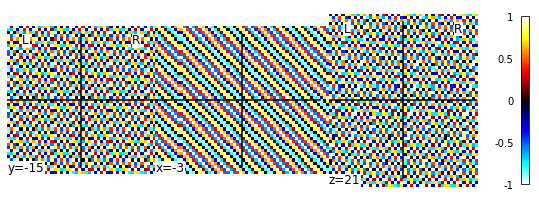

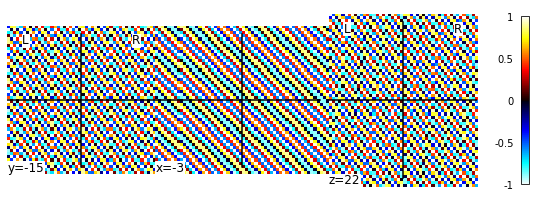

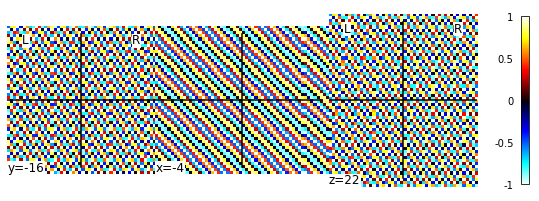

In [49]:
data_shape = (48, 56, 48)
n = 5
simdat = SimulationDataset(shape=data_shape, n_samples=3)
simdat_loader = DataLoader(simdat, batch_size=1)

simexamples = list(enumerate(simdat_loader))
for d in simexamples:
    simni = recreate_im(d[1])
    plotting.plot_stat_map(simni)

In [50]:
# minfl = '../data/sim_simplified_data/model_final.pt'
# minfl = '../data/sim_tanh/model_final.pt'
minfl = '../data/the_big_sim/model_epoch_267.pt'
simmodel = torch.load(minfl, map_location="cpu")
if isinstance(simmodel, dict):
    tmpmodel = Autoencoder3D()
    tmpmodel.load_state_dict(simmodel['model_state_dict'])
    simmodel = tmpmodel

simmodel = simmodel.eval()

In [51]:
simmodel

Autoencoder3D(
  (relu): ReLU(inplace)
  (sigm): Sigmoid()
  (tanh): Softsign()
  (conv1): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (deconv4): ConvTranspose3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (unpool3): Upsample(scale_factor=2.0, mode=nearest)
  (deconv3): ConvTranspose3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (unpool2): MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
  (deconv2): ConvTranspose3d(32, 32, kernel

In [52]:
s_inn = groom(simni)
s_out = simmodel(s_inn)

s_inim = recreate_im(s_inn)
s_outim = recreate_im(s_out)

In [53]:
print("Orig:")
print(s_inn.min(), s_inn.max())
print(my_mse(tensor2np(s_inn), np.zeros_like(tensor2np(s_inn))))

print("\nReconst:")
print(s_out.min(), s_out.max())
print(my_mse(tensor2np(s_out), np.zeros_like(tensor2np(s_out))))

Orig:
tensor(-1.) tensor(1.)
0.5002073

Reconst:
tensor(-0.9818, grad_fn=<MinBackward1>) tensor(0.9905, grad_fn=<MaxBackward1>)
0.22797197


In [54]:
distance = nn.MSELoss()

print(distance(s_inn, s_out))
print(my_mse(tensor2np(s_inn), tensor2np(s_out)))

tensor(0.2661, grad_fn=<MeanBackward0>)
0.2661298


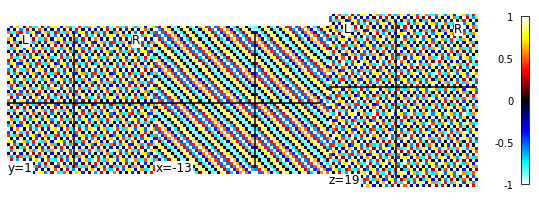

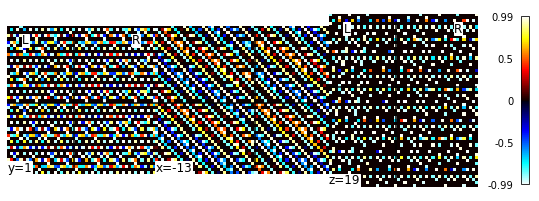

In [55]:
plotting.plot_stat_map(s_inim,  cut_coords=[-13, 1, 19], threshold=0)
plotting.plot_stat_map(s_outim, cut_coords=[-13, 1, 19], threshold=0)